In [1]:
import keras
keras.__version__

'2.4.3'

In [2]:
import os, shutil

In [3]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/Users/xmh/AI_mask/mask_data'

# Directories for our training,
# validation and test splits
train_dir = os.path.join(original_dataset_dir, 'train')
validation_dir = os.path.join(original_dataset_dir, 'validation')
test_dir = os.path.join(original_dataset_dir, 'test')

# Directory with our training mask pictures
train_mask_dir = os.path.join(train_dir, 'mask')

# Directory with our training no_mask pictures
train_no_mask_dir = os.path.join(train_dir, 'no_mask')

# Directory with our validation mask pictures
validation_mask_dir = os.path.join(validation_dir, 'mask')

# Directory with our validation no_mask pictures
validation_no_mask_dir = os.path.join(validation_dir, 'no_mask')

# Directory with our validation mask pictures
test_mask_dir = os.path.join(test_dir, 'mask')

# Directory with our validation no_mask pictures
test_no_mask_dir = os.path.join(test_dir, 'no_mask')



In [4]:
print('total training mask images:', len(os.listdir(train_mask_dir)))

print('total training no_mask images:', len(os.listdir(train_no_mask_dir)))

print('total validation mask images:', len(os.listdir(validation_mask_dir)))

print('total validation no_mask images:', len(os.listdir(validation_no_mask_dir)))

print('total test mask images:', len(os.listdir(test_mask_dir)))

print('total test no_mask images:', len(os.listdir(test_no_mask_dir)))



total training mask images: 161
total training no_mask images: 160
total validation mask images: 40
total validation no_mask images: 40
total test mask images: 20
total test no_mask images: 20


## InceptionV3

In [6]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

87916544/87910968 [==============================] - 4s 0us/step


In [11]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 26,487,457
Non-trainable params: 34,432
_________________________________________________________________


In [12]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 192
This is the number of trainable weights after freezing the conv base: 4


In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=4,
      verbose=2)

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
20/20 - 29s - loss: 0.8947 - acc: 0.6781 - val_loss: 0.4161 - val_acc: 0.7750
Epoch 2/30
20/20 - 30s - loss: 0.3888 - acc: 0.8438 - val_loss: 0.3399 - val_acc: 0.8375
Epoch 3/30
20/20 - 27s - loss: 0.3885 - acc: 0.8281 - val_loss: 0.2617 - val_acc: 0.9000
Epoch 4/30
20/20 - 27s - loss: 0.3011 - acc: 0.8594 - val_loss: 0.3278 - val_acc: 0.8500
Epoch 5/30
20/20 - 26s - loss: 0.3717 - acc: 0.8250 - val_loss: 0.2655 - val_acc: 0.8750
Epoch 6/30
20/20 - 27s - loss: 0.3079 - acc: 0.8500 - val_loss: 0.3721 - val_acc: 0.8250
Epoch 7/30
20/20 - 27s - loss: 0.2103 - acc: 0.9031 - val_loss: 0.2790 - val_acc: 0.8875
Epoch 8/30
20/20 - 27s - loss: 0.2777 - acc: 0.8906 - val_loss: 0.2490 - val_acc: 0.9125
Epoch 9/30
20/20 - 27s - loss: 0.2183 - acc: 0.9062 - val_loss: 0.2239 - val_acc: 0.9000
Epoch 10/30
20/20 - 27s - loss: 0.1756 - a

In [15]:
model.save('mask_InceptionV3.h5')

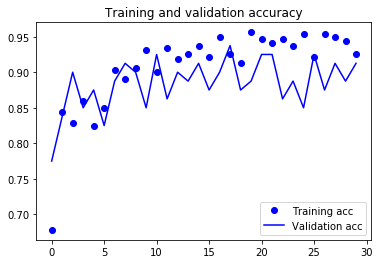

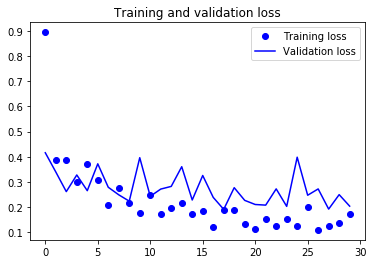

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ResNet

In [18]:
from keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

94773248/94765736 [==============================] - 4s 0us/step


In [19]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 36,642,305
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 216
This is the number of trainable weights after freezing the conv base: 4


In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=4,
      verbose=2)

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/30
20/20 - 27s - loss: 0.7334 - acc: 0.5281 - val_loss: 0.6841 - val_acc: 0.5250
Epoch 2/30
20/20 - 30s - loss: 0.7166 - acc: 0.5344 - val_loss: 0.6768 - val_acc: 0.5250
Epoch 3/30
20/20 - 32s - loss: 0.7116 - acc: 0.5312 - val_loss: 0.6988 - val_acc: 0.5375
Epoch 4/30
20/20 - 35s - loss: 0.7190 - acc: 0.4812 - val_loss: 0.7090 - val_acc: 0.5375
Epoch 5/30
20/20 - 31s - loss: 0.7295 - acc: 0.4625 - val_loss: 0.6738 - val_acc: 0.5000
Epoch 6/30
20/20 - 31s - loss: 0.7184 - acc: 0.4906 - val_loss: 0.6739 - val_acc: 0.6125
Epoch 7/30
20/20 - 30s - loss: 0.7084 - acc: 0.5000 - val_loss: 0.6754 - val_acc: 0.6000
Epoch 8/30
20/20 - 33s - loss: 0.7222 - acc: 0.5031 - val_loss: 0.6661 - val_acc: 0.6500
Epoch 9/30
20/20 - 35s - loss: 0.7098 - acc: 0.4969 - val_loss: 0.6697 - val_acc: 0.6250
Epoch 10/30
20/20 - 32s - loss: 0.7093 - acc: 0.4781 - val_loss: 0.6741 - val_acc: 0.6625
Epoch 11/30
20/20 - 30s - lo

In [23]:
model.save('mask_ResNet50.h5')

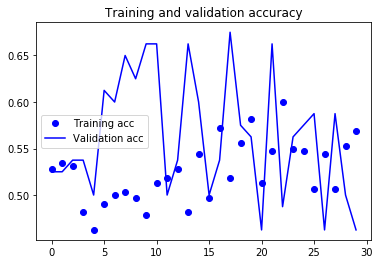

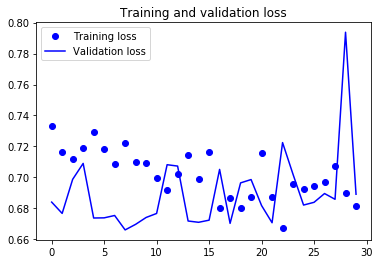

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()